# Pytorch 개발 Process

1. **데이터 준비**
    - Dataset 준비
    - Dataloader 생성

2. **입력과 출력을 연결하는 Layer(층)으로 이뤄진 네트워크(모델)을 정의**
    - **Sequential 방식**: 순서대로 쌓아올린 네트워크로 이뤄진 모델을 생성하는 방식
        - layer를 순서대로 쌓은 모델을 구현할때 간단히 모델을 정의할 수 있다.
        - layer block을 정의하는데 사용할 수 있다.
    - **Subclass 방식**: 네트워크를 정의하는 클래스를 구현.
        - 다양한 구조의 모델을 정의할 수 있다.
        - inializer에서 필요한 layer들을 생성한다.
        - forward(self, X) 메소드에 forward propagation 계산을 구현한다.
    

3. **train**
    - train 함수, test 함수 정의

4. test set 최종평가

# MNIST 이미지 분류 
- **[MNIST](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4) (Modified National Institute of Standards and Technology) database**
- 흑백 손글씨 숫자 0-9까지 10개의 범주로 구분해놓은 데이터셋
- 하나의 이미지는 28 * 28 pixel 의 크기
- 6만개의 Train 이미지와 1만개의 Test 이미지로 구성됨.

## import

In [ ]:
# !uv pip install matplotlib -U

Resolved 11 packages in 331ms
Installed 6 packages in 633ms
 + contourpy==1.3.3
 + cycler==0.12.1
 + fonttools==4.60.1
 + kiwisolver==1.4.9
 + matplotlib==3.10.7
 + pyparsing==3.2.5


In [ ]:
import torch
import torch.nn as nn  # 다양한 layer/모델 들이 정의된 패키지. (Neural Network)
from torch.utils.data import DataLoader # DataLoader 클래스 -> 모델에 데이터들을 제공(feed)하는 역할.
from torchvision import datasets, transforms 
# torchvision 패키지(라이브러리): pytorch의 영상상 전용 sub package
## datasets(모듈): Vision(영상)관련 공개데이터셋들을 제공하는 모듈
## transforms: 영상 데이터 전처리 기능들을 제공하는 모듈
## https://huggingface.co/

import matplotlib.pyplot as plt

### device 설정

In [4]:
# 어느 Device에서 연산처리를 할지 지정. (cpu, cuda(GPU))
# device = "cpu"
print(torch.cuda.is_available())  # cuda를 사용할 수있는 환경인지 조회
device = "cuda" if torch.cuda.is_available() else "cpu" # 2.0이전: torch.Device("cuda")
print(device)

False
cpu


In [ ]:
# MAC OS  ("cpu", "mps")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

### 하이퍼파라미터, 변수 설정

In [5]:
lr = 0.001 # 학습률. 0 ~ 1 실수. 
batch_size = 256  # 모델이 학습할 때 한 번에 몇 개씩 모델에 제공할지 개수. 
epochs = 20
# step: 모델의 파라미터들을 update하는 단위.
#  - 1 step: batch_size(256)개수의 데이터로 파라미터를 한번 update한 것.
# epoch: train set 전체를 학습하는 단위. 
#  - 1 epoch: 전체 데이터를 한번 다 학습한 것.

In [6]:
import os
# 학습이 끝난 모델을 저장할 디렉토리.
saved_dir = "models"
os.makedirs(saved_dir, exist_ok=True)
# Dataset을 저장할 디렉토리
dataset_dir = "datasets/mnist"
os.makedirs(dataset_dir, exist_ok=True)

### MNIST dataset Loading

#### Dataset

In [ ]:
trainset = datasets.MNIST(
    root=dataset_dir, # Dataset을 읽어올 디렉토리.
    download=True,    # root 에 dataset이 없을 경우 다운로드 받을지 여부.
    transform=transforms.ToTensor()     # 처음엔 주석(실제이미지를 본다) 주석푼후(텐서데이터로 보인다)
)
testset = datasets.MNIST(
    root=dataset_dir,
    download=True,
    train=False,       # Trainset인지 여부. True(default): train set, False: test set
    transform=transforms.ToTensor()
)
######################################################################################
#  transform=함수 -> input data를 전처리하는 함수를 전달.
######################################################################################
# transforms.ToTensor 가 하는 처리
## ndarray, PIL.Image 객체를 torch.Tensor 로 변환.
## (height, width, channel) 순서를 channel first (channel, height, width) 형태로 변환.
## pixcel값들(0~255 정수)을 0 ~ 1 로 정규화. (Feature Scaling - MinMaxScaling)
# 필로우를 포함한 대부분 이미지 라이브러리들은 (h,w,c)로 되어있음. 파이토치는 (c,h,w)임

In [24]:
# testset
trainset

Dataset MNIST
    Number of datapoints: 60000
    Root location: datasets/mnist
    Split: Train
    StandardTransform
Transform: ToTensor()

In [25]:
type(trainset)

torchvision.datasets.mnist.MNIST

In [26]:
# 개별데이터 조회
trainset[0]  # tuple: (input, output)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [27]:
# 첫번째[0] input[0]
print(trainset[0][1])
trainset[0][0]

5


tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [31]:
import numpy as np
a = np.array(trainset[0][0])  # PIL.Image -변환-> ndarray
print(a.shape, a.dtype)     # image shape (height, width), unint8(부호없는 int 0~255)
a.min(), a.max()

(1, 28, 28) float32


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14404\1226214786.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  a = np.array(trainset[0][0])  # PIL.Image -변환-> ndarray


(np.float32(0.0), np.float32(1.0))

In [38]:
################ transforms.ToTensor() 적용 후 확인################
f1 = trainset[0][0]
print(f1.shape)  # (1:channel-grayscale, 28: height, 28:width)
print(f1.dtype, f1.type())
print(f1.min(), f1.max())

torch.Size([1, 28, 28])
torch.float32 torch.FloatTensor
tensor(0.) tensor(1.)


60000


C:\Users\Administrator\AppData\Local\Temp\ipykernel_14404\2547952733.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img)     # 나중에 주석처리


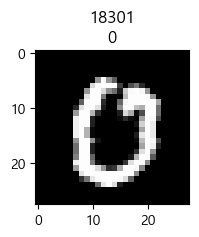

In [32]:
import random
print(len(trainset))
idx = random.randint(0, len(trainset)) #0 ~ 60000 사이 랜덤 정수를 반환.
img, label = trainset[idx]

img = np.array(img)     # 나중에 주석처리

plt.figure(figsize=(2, 2))
plt.imshow(img.squeeze(), cmap="gray") # (1, 28, 28) -> (28, 28). matplotlib은 이미지를 (h, w, c) 로 전달해야함.
plt.title(f"{idx}\n{label}")
plt.show()    

#### DataLoader

In [33]:
# DataLoader: Dataset의 데이터들을 모델에 제공하는 역할. 데이터들을 모델에 어떻게 제공할지 설정해서 생성.
# Dataset: 데이터들을 가지고 있는 역할. 하나씩 조회하는 기능을 제공.
train_loader = DataLoader(
    trainset,              # Dataset
    batch_size=batch_size, # batch size (256)
    shuffle=True,   # 모델에 데이터를 제공하기 전에 섞을지 여부. (default: False) True: 한 epoch 학습 전에 섞는다.
    drop_last=True, # 모델에 제공할 데이터의 개수가 batch_size보다 적으면 제공하지 않는다. (학습에 사용안함)
)

test_loader = DataLoader(testset, batch_size=batch_size)

In [34]:
# 전체 데이터 개수.
len(trainset), len(testset)

(60000, 10000)

In [35]:
# 1 epoch 당 step 수 조회.
len(train_loader), len(test_loader)

(234, 40)

In [37]:
60000/256, 10000/256

(234.375, 39.0625)

### 모델 정의

In [ ]:
# Class로 구현
## - nn.Module 상속한 클래스를 정의.
## - __init__(): 입력값을 추론(순전파 연산)하는데 필요한 layer객체들을 생성.
## - forward(): __init__() 에서 생성한 layer들을 이용해 연산 로직을 정의

In [39]:
28 * 28 # = 784(픽셀수 -> feature)

784

In [40]:
# (256, 1, 28, 28)       # 1번축부터 flatten 0번축은 갯수라서 제외
a =  torch.randn(256,1,28,28)
a.shape
b =  torch.flatten(a)
c =  torch.flatten(a, start_dim=1)
b.shape, c.shape


(torch.Size([200704]), torch.Size([256, 784]))

In [ ]:
weight = torch.randn(784, 128)
bias = torch.randn(128)
f = c @ weight + bias
f.shape

torch.Size([256, 128])

In [ ]:
class MNISTModel(nn.Module):
    def __init__(self):
        super().__init__()  # 상위클래스 nn.Module 을 초기화.
        
        # Linear(input feature 개수, output feature 개수)
        self.lr1 = nn.Linear(784, 128) # (784:(28*28): MNIST 이미지의 pixcel수, 출력: 128) -> 784개받아서 128개로 줄인다(w,b값으로)
        self.lr2 = nn.Linear(128, 64)  # (128: lr1의 출력개수, 출력: 64)
        self.lr3 = nn.Linear(64, 32)   # (64:  lr2의 출력개수, 출력: 32)
        self.lr4 = nn.Linear(32, 10)   # (32:  lr3의 출력개수, 출력: 10)
        # 마지막 Linear()의 출력 개수(10) - 분류할 class개수(0 ~ 9)

    def forward(self, X):
        """
        X를 입력 받아서 y를 추론하는 계산로직을 정의
        initializer에서 정의한 Linear들을 이용해서 계산.
        Args:
            X(torch.FloatTensor) - 추론할 MNIST 이미지들. shape: (batch_size, 1, 28, 28)
        """
        # (batch_size, 1, 28, 28) 를 (batch_size, 784) feature들을 1차원으로 변환.
        X = torch.flatten(X, start_dim=1) # 다차원 배열을 1차원 배열로 변환. (start_dim=1, Flatten 시킬 시작 axis지정. 0축은 놔두고 1축 부터 flatten시킨다.)
        X = self.lr1(X)  # Linear: 선형함수
        X = nn.ReLU()(X) # Activation(활성) 함수. 비선형함수. ReLU(x): max(x, 0)
        
        X = self.lr2(X)
        X = nn.ReLU()(X)
        
        X = self.lr3(X)
        X = nn.ReLU()(X)
        
        output = self.lr4(X)
        return output

In [63]:
x = torch.randn(256, 1, 28 ,28)
model = MNISTModel()
p =  model(x)       # forward()
p.shape     
p[0]        # 각 플래스별 확률(을 계산하기전값 - logit) 확률이 마이너스는 없지만.....마이너스값은 확률값이 낮다는의미
p[0].argmax().item()
p[0].argmax(dim=-1)

tensor(0)

In [61]:
a[1]

tensor([0, 6, 8, 4, 7, 5, 2, 7, 5, 2, 4, 3, 4, 1, 3, 8, 5, 2, 4, 5, 4, 4, 2, 3,
        4, 4, 4, 2, 7, 5, 2, 6, 8, 9, 7, 9, 2, 6, 9, 7, 8, 6, 2, 7, 7, 0, 1, 9,
        3, 8, 9, 5, 0, 5, 9, 4, 4, 7, 0, 1, 6, 2, 0, 1, 8, 2, 2, 8, 1, 3, 1, 8,
        9, 2, 6, 3, 3, 0, 4, 0, 6, 8, 5, 9, 8, 6, 9, 8, 1, 7, 9, 0, 3, 9, 8, 8,
        6, 3, 8, 5, 4, 3, 9, 7, 5, 3, 0, 5, 8, 9, 3, 6, 2, 1, 4, 9, 1, 2, 9, 9,
        8, 8, 3, 0, 3, 7, 4, 8, 6, 6, 9, 1, 9, 7, 7, 6, 9, 8, 8, 6, 9, 3, 5, 2,
        6, 0, 0, 4, 8, 5, 2, 7, 5, 2, 2, 0, 4, 0, 7, 3, 4, 5, 2, 6, 9, 8, 2, 2,
        4, 9, 7, 6, 0, 1, 1, 0, 2, 9, 6, 5, 7, 3, 0, 1, 0, 0, 5, 5, 6, 2, 9, 8,
        8, 3, 6, 2, 0, 2, 1, 3, 8, 3, 8, 6, 1, 6, 5, 2, 1, 4, 7, 7, 9, 2, 7, 4,
        9, 0, 3, 3, 4, 1, 1, 6, 4, 6, 6, 9, 9, 5, 6, 1, 6, 5, 3, 4, 3, 3, 6, 8,
        7, 3, 3, 8, 1, 0, 9, 8, 2, 3, 3, 7, 5, 6, 7, 8])

### Train

#### 모델, loss function, optimizer 생성

In [65]:
# 모델객체 생성
model = MNISTModel()
# 확인
print(model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


In [66]:
# Loss함수 - 학습 할 때 모델이 예측한 값과 정답간의 오차를 계산하는 함수. 이 오차를 줄이는 방향으로 파라미터를 변경한다.
# 다중 분류 문제의 Loss함수: crossentropyloss함수. (이진분류: binary crossentropy, 회귀: mse)
loss_fn = nn.CrossEntropyLoss()  # torch.nn.functional.cross_entropy 함수사용도 가능.

In [46]:
# optimizer 정의: 모델의 파라미터들을 업데이트하고 파라미터들의 gradient값을 초기화 한다.
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [58]:
for param in model.parameters():
    print(param.shape)
    print("--------------------------------------")

torch.Size([128, 784])
--------------------------------------
torch.Size([128])
--------------------------------------
torch.Size([64, 128])
--------------------------------------
torch.Size([64])
--------------------------------------
torch.Size([32, 64])
--------------------------------------
torch.Size([32])
--------------------------------------
torch.Size([10, 32])
--------------------------------------
torch.Size([10])
--------------------------------------


In [ ]:
for e in range(epochs):
    # 모델학습
    model.train()

    # 모델검증
    model.eval()

#### 학습(훈련-train) 및 검증

In [ ]:
for a in train_loader:
    print(type(a))
    break
# 한 번 반복문 돌때마다 1batch 반환받는다

<class 'list'>


In [60]:
a[0].shape, a[1].shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

In [ ]:
# 학습시 계산에 사용되는 값들은 같은 device(cpu or cuda or mps)에 있어야 한다
## device로 이동할 대상: Model객체, X(input), y(output)

In [67]:
model = MNISTModel().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [68]:
import time
# 학습
## 한 학습이 
## 에폭별 검증결과들을 저장할 리스트
train_loss_list = []
valid_loss_list = []
valid_acc_list = []
s = time.time()

# 학습-중첩 반복문: epoch 반복 -> step(batch_size) 에 대한 반복
for epoch in range(epochs):
    # 1. 에폭학습 = Train + Validation 두 단계로 구성
    ###############################################
    # 모델 Train - 1 epoch : Trainset
    ###############################################
    model.train()  # 모델을 train 모드로 변환.
    train_loss = 0 # 현재 epoch의 train loss를 저장할 변수.

    # batch 단위로 학습: 1 step - 1개 batch의 데이터로 학습.
    for X_train, y_train  in train_loader: # 한번 반복할 때마다 1개 batch 데이터를 순서대로 제공. (X, y) 를 묶어서 제공한다.
        # 1. X, y를 devcie로 이동(model과 같은 device로 이동)
        X_train, y_train = X_train.to(device), y_train.to(device)

        # 2. 모델을 이용해 추론
        pred = model(X_train) # Model.forward(X_train) 메소드 호출

        # 3. loss 계산
        loss = loss_fn(pred, y_train)   # (모델추론결과, 정답)  시이킷런(정답, 추론)과 반대다

        # 4. gradient 계산
        loss.backward()

        # 5. 모델의 파라미터들(weight, bias) update
        optimizer.step()

        # 6. gradient 초기화
        optimizer.zero_grad()

        # 학습 결과 저장및 출력을 위해 loss 저장.   (1 step에 대한 loss를 누적)
        train_loss = train_loss + loss.item() 
    
    # 1 epoch 학습이 종료
    train_loss = train_loss / len(train_loader)  # 한 에폭에서 학습한 step별 loss의 평균계산.
    train_loss_list.append(train_loss)
    
    ###############################################
    # 1 epoch 학습한 결과 검증: Testset
    ###############################################
    model.eval()  # 모델을 evaluation() (추론, 검증) 모드로 변환.
    valid_loss = 0      # 현재 epoch에 대한 검증결과(loss, accuracy) 저장할 변수
    valid_acc = 0
    with torch.no_grad(): # 추론만 함 -> gradient 계산할 필요 없음. -> grad_fn 구할 필요없다.
        for X_valid, y_valid in test_loader:
            # 1. device 로 이동
            X_valid, y_valid = X_valid.to(device), y_valid.to(device)

            # 2. 추론
            pred_valid = model(X_valid)

            # 3-1. 검증 -> loss 계산
            valid_loss = valid_loss + loss_fn(pred_valid, y_valid).item()
            
            # 3-2. 검증 -> accuracy 계산
            ## pred_valid shape: (256, 10: class별 확률) -> 정답 class 추출
            pred_valid_class = pred_valid.argmax(dim=-1)
            valid_acc = valid_acc + torch.sum(y_valid == pred_valid_class).item()
        
        # 검증결과 누적값의 평균
        valid_loss = valid_loss / len(test_loader)  # loss는 step수 나눔.
        valid_acc = valid_acc / len(testset)        # accuracy는 데이터 개수로 나눔.
        valid_loss_list.append(valid_loss)
        valid_acc_list.append(valid_acc)

        # 검증 결과 출력
        print(f"[{epoch+1:02d}/{epochs}] train_loss: {train_loss}, valid_loss: {valid_loss}, valid_acc: {valid_acc}")

e = time.time()
print('학습에 걸린 시간(초):', e-s)
# 모델의 성능은 일반적으로 검증 손실(valid_loss)이 가장 낮고, 동시에 검증 정확도(valid_acc)가 높은 지점에서 결정됩니다


[01/20] train_loss: 0.65694850944301, valid_loss: 0.2654335778206587, valid_acc: 0.9217
[02/20] train_loss: 0.2416361595193545, valid_loss: 0.19222552909050136, valid_acc: 0.941
[03/20] train_loss: 0.1761094695673539, valid_loss: 0.15712888622656465, valid_acc: 0.9529
[04/20] train_loss: 0.1378143925506335, valid_loss: 0.12072765484917909, valid_acc: 0.9636
[05/20] train_loss: 0.11302058776028645, valid_loss: 0.11613959503592923, valid_acc: 0.9648
[06/20] train_loss: 0.09349782874759956, valid_loss: 0.0983996331517119, valid_acc: 0.9686
[07/20] train_loss: 0.07736822138102646, valid_loss: 0.09573743358487263, valid_acc: 0.9699
[08/20] train_loss: 0.06704865478807026, valid_loss: 0.09840650571277365, valid_acc: 0.97
[09/20] train_loss: 0.059320052647883564, valid_loss: 0.08954592038644478, valid_acc: 0.9708
[10/20] train_loss: 0.05167986288603045, valid_loss: 0.0892522171488963, valid_acc: 0.9714
[11/20] train_loss: 0.04411784644660532, valid_loss: 0.0863757138577057, valid_acc: 0.9725


#### 학습 로그 시각화

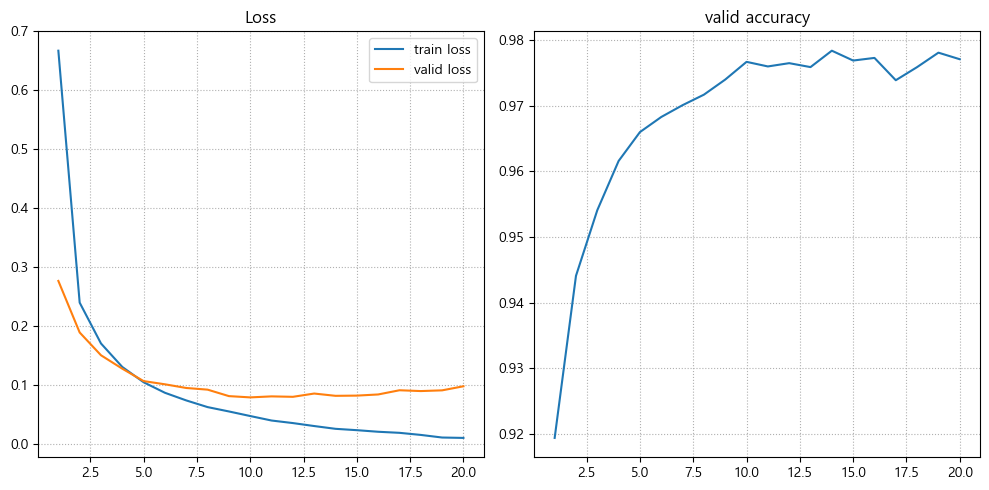

In [ ]:
# train loss, valid loss, valid acc 를 epoch 별로 어떻게 변하는지 시각화.
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_loss_list, label="train loss")
plt.plot(range(1, epochs+1), valid_loss_list, label="valid loss")
plt.title("Loss")
plt.legend()
# plt.ylim(0, 0.3)      loss를 상세하게 보기
plt.grid(True, linestyle=":")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), valid_acc_list)
plt.title("valid accuracy")

plt.tight_layout()
plt.grid(True, linestyle=":")
plt.show()


### 학습된 모델 저장 및 불러오기

In [71]:
import os
saved_dir = "models"
os.makedirs(saved_dir, exist_ok=True)

save_path = os.path.join(saved_dir, "mnist_model.pt")
save_path

'models\\mnist_model.pt'

In [72]:
# 모델 저장: 파일 확장자 - pt, pth
torch.save(model, save_path)  #  (저장할 모델, 저장할 파일 경로)

In [ ]:
# 저장된 모델 load(불러오기)
load_model = torch.load(save_path, weights_only=False)      # weights_only=True : 파라미터 
만 저장
print(load_model)

MNISTModel(
  (lr1): Linear(in_features=784, out_features=128, bias=True)
  (lr2): Linear(in_features=128, out_features=64, bias=True)
  (lr3): Linear(in_features=64, out_features=32, bias=True)
  (lr4): Linear(in_features=32, out_features=10, bias=True)
)


## 모델 성능 최종 평가

In [74]:
load_model = load_model.to(device)
load_model.eval() # 평가모드

test_loss = test_acc = 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        # device 이동
        X_test, y_test = X_test.to(device), y_test.to(device)

        # 추론
        pred_test = load_model(X_test)

        # 검증 - loss
        loss_test = loss_fn(pred_test, y_test)
        
        test_loss += loss_test.item()
        # 검증 - accuracy
        ## class
        pred_test_class = pred_test.argmax(dim=-1)
        test_acc += torch.sum(pred_test_class == y_test).item()

    test_loss = test_loss / len(test_loader)
    test_acc = test_acc / len(testset)

In [75]:
print(test_loss, test_acc)

0.10589810602723446 0.9737


In [77]:
X_test.shape

torch.Size([16, 1, 28, 28])

In [76]:
p = load_model(X_test)
p.shape

torch.Size([16, 10])

In [80]:
p_class = p.argmax(dim=-1)
p_class.shape
p_class

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [83]:
y_test == p_class
torch.sum(y_test == p_class).item() # 맞은 것의 개수.

16

## 새로운 데이터 추론

In [85]:
from PIL import Image
# python 에서 이미지 다루기 : OpenCV, PIL(Pillow)

def load_data(device="cpu", *path):
    """
    받은 경로의 이미지들을 읽어서 Tensor로 변환해 반환한다.

    1. 전달받은 경로의 이미지 파일들을 읽는다.
    2. 28 x 28 로 resize
    3. torch.Tensor로 변환 + 전처리
    4. devcie로 이동시킨 뒤 반환한다다.
    """
    input_tensors = []
    for p in path:
        img = Image.open(p)     # return: PIL.Image
        img = img.convert('L')     # color -> grayscale로 변환.
        img = img.resize((28, 28)) # 모델이 학습한 데이터 size(28, 28)로 변환.
        img = transforms.ToTensor()(img)   
        # Image -> torch.Tensor, channel first (1,28,28), 정규화(0~255 -> 0~1)
        input_tensors.append(img)
        
    return torch.stack(input_tensors).to(device)

In [87]:
def predict(model, inputs, device="cpu"):
    """
    받은 model에 inputs를 추론하여 그 결과 class들을 반환한다.
    """
    with torch.no_grad():
        model = model.to(device)
        model.eval()
        pred = model(inputs)
        pred_class = pred.argmax(dim=-1)
        return pred_class

In [ ]:
# with torch.no_grad 대신 torch.no_grad decorator를 사용해서 grad_fn을 구하지 않도록
# 할수있다
@torch.no_grad
def predict(model, inputs, device="cpu"):
    """
    받은 model에 inputs를 추론하여 그 결과 class들을 반환한다.
    """
    model = model.to(device)
    model.eval()
    pred = model(inputs)
    pred_class = pred.argmax(dim=-1)
    return pred_class

In [88]:
r = load_data('cpu', 'test_img/eight.png', 'test_img/four.png')
r.shape
predict(load_model, r)

tensor([2, 4])

In [89]:
# glob을 이용해 테스트 이미지들의 경로 조회.
from glob import glob
# file_list = glob("<<IMAGES 경로>>")
file_list = glob('test_img/*.png')
file_list

['test_img\\eight.png',
 'test_img\\eight2.png',
 'test_img\\five.png',
 'test_img\\four.png',
 'test_img\\four2.png',
 'test_img\\one.png',
 'test_img\\seven.png',
 'test_img\\seven2.png',
 'test_img\\seven3.png',
 'test_img\\three.png',
 'test_img\\three2.png',
 'test_img\\two.png',
 'test_img\\two2.png']

In [98]:
def test(device="cpu", *path):
    print(len(path), path)
    
test(device, *file_list)

13 ('test_img\\eight.png', 'test_img\\eight2.png', 'test_img\\five.png', 'test_img\\four.png', 'test_img\\four2.png', 'test_img\\one.png', 'test_img\\seven.png', 'test_img\\seven2.png', 'test_img\\seven3.png', 'test_img\\three.png', 'test_img\\three2.png', 'test_img\\two.png', 'test_img\\two2.png')


In [92]:
r = load_data(device, *file_list)
print(r.shape)
result_pred = predict(load_model, r)
result_pred

torch.Size([13, 1, 28, 28])


tensor([2, 3, 5, 4, 4, 6, 7, 2, 2, 3, 3, 2, 2])

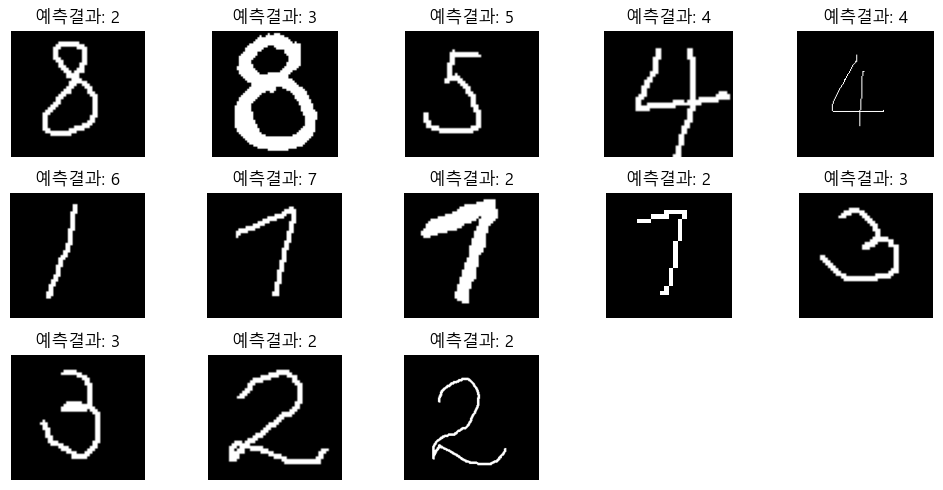

In [97]:
# 확인
# plt.rcParams['font.family'] = 'malgun gothic'
plt.figure(figsize=(10, 5))
for idx, (path, label) in enumerate(zip(file_list, result_pred)):
    # print(idx, path, label, sep=" , ")
    img = Image.open(path).convert('L')
    plt.subplot(3, 5, idx+1)  #3, 4
    plt.imshow(img, cmap="gray")
    plt.title(f"예측결과: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()